## 1 Risk and Return Recap

Import Data

In [11]:
# Import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas_datareader as web
import datetime

# Read in the csv file and parse dates
#portfolio = pd.read_csv('portfolio.csv', parse_dates=['date'], index_col = 'date')
#  Assets to be included in the portfolio
tickers = ['C', 'MS', 'GS', 'JPM']
portfolio = web.get_data_yahoo(tickers, start = '2005-01-01',end = '2010-12-31')
portfolio = portfolio['Adj Close']
# Ensure the prices are sorted by Date
portfolio = portfolio.sort_values(by='Date')
print(portfolio.head())

Symbols              C         MS         GS        JPM
Date                                                   
2004-12-31  357.146545  34.408672  85.005226  25.232813
2005-01-03  357.813782  34.644173  85.748734  25.323364
2005-01-04  354.774445  34.272320  85.193153  25.062368
2005-01-05  359.222229  34.074001  84.809174  25.114561
2005-01-06  362.706207  34.879677  85.977524  25.258123


1.Portfolio returns during the crisis

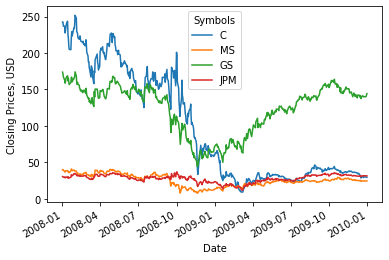

In [12]:
# Select portfolio asset prices for the middle of the crisis, 2008-2009
asset_prices = portfolio.loc['2008-01-01':'2009-12-31']
# Plot portfolio's asset prices during this time
asset_prices.plot().set_ylabel("Closing Prices, USD")
plt.show()

2. Asset covariance and portfolio volatility

In [14]:
# Calculate daily returns of stocks
asset_returns=asset_prices.pct_change()

# Generate the covariance matrix from portfolio asset's returns
covariance = asset_returns.cov()

# Annualize the covariance using 252 trading days per year
covariance = covariance * 252

# Display the covariance matrix
print("covariance: " + str(covariance)+'\n')

# Compute and display portfolio (4 banks equal weights) volatility for 2008 - 2009
weights= [0.25, 0.25, 0.25, 0.25]
portfolio_variance = np.transpose(weights) @ covariance @ weights
portfolio_volatility = np.sqrt(portfolio_variance)
print('\n'+"portfolio_volatility: " + str(portfolio_volatility))


covariance: Symbols         C        MS        GS       JPM
Symbols                                        
C        1.476085  0.823336  0.572946  0.725392
MS       0.823336  1.298745  0.659088  0.561084
GS       0.572946  0.659088  0.500628  0.427097
JPM      0.725392  0.561084  0.427097  0.685469


portfolio_volatility: 0.8477474989685946


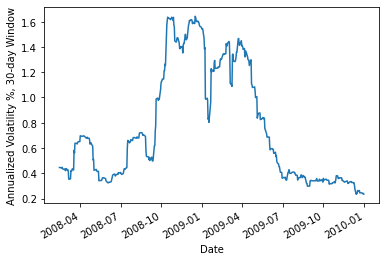

In [15]:
# Calculate the 30-day rolling window of portfolio returns
portfolio_returns=asset_returns@weights

returns_windowed = portfolio_returns.rolling(30)

# Compute the annualized volatility series
volatility_series = returns_windowed.std()*np.sqrt(252)

# Plot the portfolio volatility
volatility_series.plot().set_ylabel("Annualized Volatility %, 30-day Window")
plt.show()

3. Resample to quarterly and weekly frequency

In [16]:
# Convert daily returns to quarterly average returns
returns_q = portfolio_returns.resample('Q').mean()

# Examine the beginning of the quarterly series
print(returns_q.head())

# Now convert daily returns to weekly minimum returns
returns_w = portfolio_returns.resample('W').min()

# Examine the beginning of the weekly series
print(returns_w.head())

Date
2008-03-31   -0.001766
2008-06-30   -0.002054
2008-09-30    0.001088
2008-12-31   -0.003349
2009-03-31    0.002561
Freq: Q-DEC, dtype: float64
Date
2008-01-06   -0.025675
2008-01-13   -0.036424
2008-01-20   -0.050889
2008-01-27   -0.034475
2008-02-03   -0.001803
Freq: W-SUN, dtype: float64


4. Visualize risk factor correlation

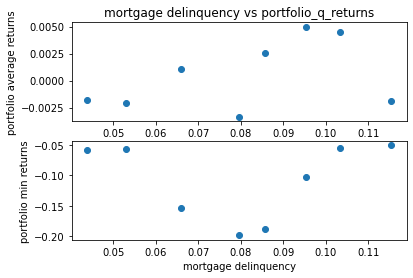

In [17]:
# mortgage delinquency rates downloaded from 
# https://fred.stlouisfed.org/series/DRSFRMACBS

MDR = pd.read_excel('MDR.xlsx',index_col='DATE')
#convert percent to decimals
MDR['MDR']=MDR['MDR']/100
mort_del=MDR.loc['2008-03-31':'2010-01-31']

# Transform the daily portfolio_returns into quarterly average returns
portfolio_q_average = portfolio_returns.resample('Q').mean().dropna()

# Transform daily portfolio_returns returns into quarterly minimum returns
portfolio_q_min = portfolio_returns.resample('Q').min().dropna()


# Create two subplots of scatterplot between delinquency
# and quarterly ave & min returns
f, (ax1, ax2) = plt.subplots(2,1)
ax1.scatter(mort_del, portfolio_q_average)
ax1.set_title('mortgage delinquency vs portfolio_q_returns')
ax2.scatter(mort_del, portfolio_q_min)
ax1.set(ylabel='portfolio average returns')
ax2.set(xlabel='mortgage delinquency',ylabel='portfolio min returns')
plt.show()

In [18]:
# align mort_del index with portfolio index
mort_del.index=portfolio_q_average.index

5. Least squares factor model

In [19]:
# Import statsmodels

import statsmodels.api as sm

# Add a constant to the regression
mort_del = sm.add_constant(mort_del)

# Create the regression factor model and fit it to the data
results = sm.OLS(portfolio_q_average, mort_del).fit()

# Print a summary of the results
print(results.summary())


# Create the regression factor model and fit it to the data
results = sm.OLS(portfolio_q_min, mort_del).fit()

# Print a summary of the results
print(results.summary())

# Resample volatilty to Q and change from % to decimal
volatility_q_ave=(volatility_series/100).resample('Q').mean().dropna()

# Create the regression factor model and fit it to the data
results = sm.OLS(volatility_q_ave, mort_del).fit()

# Print a summary of the results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     1.259
Date:                Wed, 18 Nov 2020   Prob (F-statistic):              0.305
Time:                        13:49:48   Log-Likelihood:                 35.814
No. Observations:                   8   AIC:                            -67.63
Df Residuals:                       6   BIC:                            -67.47
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0039      0.004     -0.952      0.3

C:\ProgramData\Anaconda\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [20]:
volatility_q_ave

Date
2008-03-31    0.004804
2008-06-30    0.004749
2008-09-30    0.006524
2008-12-31    0.014962
2009-03-31    0.012696
2009-06-30    0.008615
2009-09-30    0.003621
2009-12-31    0.003189
Freq: Q-DEC, dtype: float64

6. Modern Portfolio Theory with PyPortfolioOpt

In [24]:
# Load the investment portfolio price data into the price variable.
prices = portfolio.loc['2005-01-01':'2010-12-31']

# Convert the 'Date' column to a datetime index
#prices['date'] = pd.to_datetime(prices['date'], format='%d/%m/%Y')
#prices.set_index(['date'], inplace = True)

In [25]:
# pip install PyPortfolioOpt to be dobe prior to use this library
# new Visual Studio Installer might be required to install PyPortfolio

# Import the CovarianceShrinkage object
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.cla import CLA

# Create the CovarianceShrinkage instance variable
cs = CovarianceShrinkage(prices)

In [26]:
# Create a dictionary of time periods (or 'epochs')
epochs = { 'before' : {'start': '1-1-2005', 'end': '31-12-2006'},
           'during' : {'start': '1-1-2007', 'end': '31-12-2008'},
           'after'  : {'start': '1-1-2009', 'end': '31-12-2010'}
         }

# Compute the efficient covariance for each epoch
e_cov = {}
for x in epochs.keys():
  sub_price = prices.loc[epochs[x]['start']:epochs[x]['end']]
  e_cov[x] = CovarianceShrinkage(sub_price).ledoit_wolf()

# Display the efficient covariance matrices for all epochs
print("Efficient Covariance Matrices\n", e_cov)

Efficient Covariance Matrices
 {'before': Symbols         C        MS        GS       JPM
Symbols                                        
C        0.017808  0.013686  0.013218  0.013653
MS       0.013686  0.042648  0.030287  0.016673
GS       0.013218  0.030287  0.044285  0.018237
JPM      0.013653  0.016673  0.018237  0.024010, 'during': Symbols         C        MS        GS       JPM
Symbols                                        
C        0.713033  0.465995  0.323595  0.365002
MS       0.465995  0.982685  0.435152  0.299323
GS       0.323595  0.435152  0.408230  0.224653
JPM      0.365002  0.299323  0.224653  0.421978, 'after': Symbols         C        MS        GS       JPM
Symbols                                        
C        0.839374  0.345554  0.251641  0.356007
MS       0.345554  0.390643  0.232036  0.279906
GS       0.251641  0.232036  0.244098  0.223338
JPM      0.356007  0.279906  0.223338  0.381803}


## The efficient frontier and the financial crisis
Previously you examined the covariance matrix of the investment bank portfolio before, during and after the financial crisis. <br>
Now you will visualize the changes that took place in the efficient frontier, showing how the crisis created a much higher baseline risk for any given return.<br>

Using the PyPortfolioOpt pypfopt library's Critical Line Algorithm (CLA) object, you will derive and visualize the efficient frontier during the crisis period, and add it to a scatterplot already displaying the efficient frontiers before and after the crisis.<br>

Expected returns returns_during and the efficient covariance matrix ecov_during are available, as is the CLA object from pypfopt.

In [87]:
# finding annualized returns before crisis: {'start': '1-1-2005', 'end': '31-12-2006'},
total_return_before = (portfolio.loc['2006-12-29']-portfolio.loc['2005-01-03'])/portfolio.loc['2005-01-03']
returns_before=((1+total_return_before)**(1/2))-1
print(total_return_before)
print(returns_before)

Symbols
C      0.248592
MS     0.511028
GS     0.932925
JPM    0.323566
dtype: float64
Symbols
C      0.117404
MS     0.229239
GS     0.390297
JPM    0.150463
dtype: float64


In [88]:
# finding annualized returns during crisis
total_return_during = (portfolio.loc['2008-12-31']-portfolio.loc['2007-01-03'])/portfolio.loc['2007-01-03']
returns_during=((1+total_return_during)**(1/2))-1
print(total_return_during)
print(returns_during)

Symbols
C     -0.866005
MS    -0.752169
GS    -0.573114
JPM   -0.304489
dtype: float64
Symbols
C     -0.633946
MS    -0.502174
GS    -0.346635
JPM   -0.166027
dtype: float64


In [89]:
# finding annualized returns after crisis: {'start': '1-1-2009', 'end': '31-12-2010'}
total_return_after = (portfolio.loc['2010-12-31']-portfolio.loc['2009-01-05'])/portfolio.loc['2009-01-05']
returns_after=((1+total_return_after)**(1/2))-1
print(total_return_after)
print(returns_after)

Symbols
C     -0.330330
MS     0.587501
GS     0.935770
JPM    0.463995
dtype: float64
Symbols
C     -0.181667
MS     0.259961
GS     0.391320
JPM    0.209957
dtype: float64


OrderedDict([('C', 0.6748704252865606), ('MS', 0.048421720194465896), ('GS', 0.03873036776428943), ('JPM', 0.23797748675468405)])
OrderedDict([('C', 0.0), ('MS', 0.0), ('GS', 0.5180473145757697), ('JPM', 0.48195268542423025)])
OrderedDict([('C', 0.0), ('MS', 0.028481381501708203), ('GS', 0.8665949929286471), ('JPM', 0.10492362556964484)])


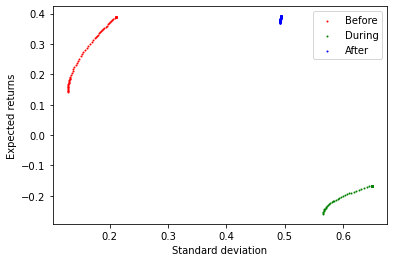

In [83]:
####Before crisis

# Initialize the Crtical Line Algorithm object
efficient_portfolio_before = CLA(returns_before, e_cov['before'])

# Find the minimum volatility portfolio weights and display them
print(efficient_portfolio_before.min_volatility())

# Compute the efficient frontier
(ret_b, vol_b, weights_b) = efficient_portfolio_before.efficient_frontier()

####During crisis

# Initialize the Crtical Line Algorithm object
efficient_portfolio_during = CLA(returns_during, e_cov['during'])

# Find the minimum volatility portfolio weights and display them
print(efficient_portfolio_during.min_volatility())

# Compute the efficient frontier
(ret_d, vol_d, weights_d) = efficient_portfolio_during.efficient_frontier()

####After crisis

# Initialize the Crtical Line Algorithm object
efficient_portfolio_after = CLA(returns_after, e_cov['after'])

# Find the minimum volatility portfolio weights and display them
print(efficient_portfolio_after.min_volatility())

# Compute the efficient frontier
(ret_a, vol_a, weights_a) = efficient_portfolio_after.efficient_frontier()

# Add the frontier to the plot showing the 'before' and 'after' frontiers
plt.scatter(vol_b, ret_b, s = 4, c = 'r', marker = '.', label = 'Before')
plt.scatter(vol_d, ret_d, s = 4, c = 'g', marker = '.', label = 'During')
plt.scatter(vol_a, ret_a, s = 4, c = 'b', marker = '.', label = 'After')
plt.xlabel('Standard deviation')
plt.ylabel('Expected returns')
plt.legend()
plt.show()

### Conclusion:
Best returns and less volatility portfolio was before crisis